[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Weeds Identification-AutoML-3

## Instructions
1. Clone the repository.
2. Download the necessary datasets from Eden Repository:
   1. Black nightsade-22/MAY/2019-v1
   2. Tomato-24/MAY/2019-v1
   3. Cotton-10/JUN/2019-v1
   4. Velvet leaf-22/MAY/2019-v1
3. Unzip dataset files and remove the zip files.
4. Create a folder called 'eden_data'.
5. Move the unzipped datasets into this folder.
6. The resulting directory structure should be:
    * eden_library_notebooks/auto_ml/
       * weeds_identification-auto_ml-3.ipynb
       * eden_data/
           * Tomato-240519-Healthy-zz-V1-...
           * Black nightsade-220519-Weed-zz-V1-...
           * Cotton-Gossypium Herbaceum-100619-Healthy-zz
           * Velvet leaf-Abutilon Theophrasti-220519-Weed-zz
7. Install notebook dependencies by running:
    <pre><code>conda env create -f autokeras-environment.yml</code></pre>
8. Open the notebook: jupyter notebook
9. Run the code

# Background
In this notebook, we are going to cover a technique called **Automated Machine Learning (AutoML)**. These systems have arisen in the past years to allow computers to automatically find the most suitable Machine Learning (ML) pipeline matching a specific task and dataset. AutoML systems could provide insights to ML engineers resulting in better models deployed in a shorter period of time. They are considered meta-level ML algorithms which use different components as building blocks for finding the optimal ML pipeline structures **(Feurer et al., 2015; Kotthoff et al., 2017)**. These systems automatically evaluate multiple pipeline configurations, trying to improve the global performance iteratively. Several open-source technologies have raised awareness of the strengths and limitations of the AutoML systems, e.g. AutoKeras, AutoSklearn, Auto-WEKA, H2O AutoML, TPOT, autoxgboost, and OBOE. Additionally, different AutoML cloud-solutions are now being offered by IT firms, such as Google Cloud AutoML Vision, Microsoft Azure Machine Learning, and Apple Create ML; they offer user-friendly interfaces and require little expertise in Machine Learning to train models. In this notebook, we will be using [**AutoKeras**](https://autokeras.com/). If you want to check out AutoSklearn, please have a look in our previous notebooks:  
1. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/auto_ml/weeds_identification-AutoML-1.ipynb  
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/auto_ml/weeds_identification-AutoML-2.ipynb

In the **agricultural domain**, some recent research studies have made use of the AutoML technique in the past few years, using it to process time series as well as proximal and satellite images. In **Hayashi et al., (2019)**, the authors tested whether AutoML was a useful tool for the identification of pest insect species by using three aphid species. They constructed models that were trained by photographs of those species under various conditions in Google Cloud AutoML Vision, and compared their accuracies of identification. Since the rates of correct identification were over 96% when the models were trained with 400 images per class, they considered AutoML to be useful for pest species identification. In **Montellano (2019)**, the author used AutoML through the same platform to classify different types of butterflies, image fruits, and larval host plants; their average accuracy was around 97.1%. In **Hsieh et al., (2019)**, AutoML was implemented along with neural network algorithms to classify whether the conditions of rice blast disease were exacerbated or relieved by using five years of climatic data. Although the experiments showed 72% accuracy on average, the model obtained an accuracy of 89% in the exacerbation case. Hence, the effectiveness of the proposed classification model, which combined multiple machine learning models, was confirmed. Finally, an AutoML approach has been applied in **Kiala et al., (2020)**, in an attempt to map the Parthenium weed. The authors constructed models by using AutoML technology and 16 other classifiers that were trained by satellite pictures of Sentinel-2 and Landsat 8. The AutoML model achieved a higher overall classification accuracy of 88.15% using Sentinel-2 and 74% using Landsat 8, results that confirmed the significance of the AutoML in mapping Parthenium weed infestations using satellite imagery. In **Koh et al., (2020)**, authors used wheat lodging assessment with UAV images for high-throughput plant phenotyping. They compared AutoKeras in image classification and regression tasks to transfer learning techniques. Finally, in **Espejo-Garcia et. al, (2021)**, the authors integrated AutoSklearn and AutoKeras for addressing the problem of weed identification in 2 different datasets.

In **agriculture**, since **weeds** compete with crops in the domain of space, light, and nutrients, they are an important problem that can lead to a poorer harvest. To avoid this, weeds should be removed at every step of growth, but especially at the initial stages. For that reason, identifying weeds accurately through Deep Learning has arisen as an important objective.

#### Library Imports

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
import random
import os
from glob import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import autokeras as ak
from keras.models import load_model

#### Check whether GPU device is available for training

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13113790846268473931
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11154422528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9962338187525598293
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


#### Auxiliar functions

In [5]:
# Callbacks are used for saving the best weights and early stopping

def get_callbacks(weights_file, patience):
    return [
        # Only save the weights that correspond to the maximum validation accuracy
        ModelCheckpoint(filepath= weights_file,
                        monitor="val_accuracy",
                        mode="max",
                        save_best_only=True, 
                        save_weights_only=True),
        # If val_loss doesn't improve for a number of epochs set with 'patience' variable 
        # training will stop to avoid overfitting
        EarlyStopping(monitor="val_accuracy",
                      mode="max",
                      patience = patience,
                      verbose=1)
        ]

In [6]:
def plot_sample(X):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0]-1)])

In [7]:
def read_data(path, im_size=(128,128)):
    
    X = []
    y = []
    # Extract the label name from data files
    tag2idx = {tag:i for i, tag in enumerate(os.listdir(path))}
    
    for im_file in tqdm(glob(path + "*/*")):
        try:
            label = im_file.split("/")[1]
            im = cv2.imread(im_file)
            im = cv2.resize(im, im_size)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            X.append(im)
            y.append(tag2idx[label])  # Appending label names to y
        except Exception as e:
            # In case annotations or metadata are found
            print("Not a picture")
    
    X = np.array(X)
    y = np.array(y).astype(np.uint8)
    
    return X, y

#### Reading Data (4 classes) and displaying some random samples from each of them
**Warning:** In case the datasets contain non-image files (annotations/metadata/licenses/OS hidden files, etc.), a "Not a picture" message will appear; this does NOT affect the technique implemented.

In [8]:
X, y = read_data("eden_data/")

 10%|█         | 52/503 [00:12<01:44,  4.31it/s]

Not a picture


 36%|███▌      | 181/503 [00:41<01:29,  3.61it/s]

Not a picture


 76%|███████▌  | 381/503 [01:48<00:37,  3.29it/s]

Not a picture


100%|██████████| 503/503 [02:16<00:00,  3.68it/s]


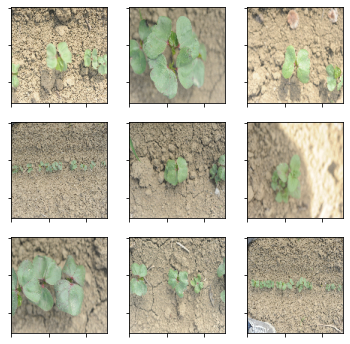

In [9]:
# Class 0
plot_sample(X[y == 0])

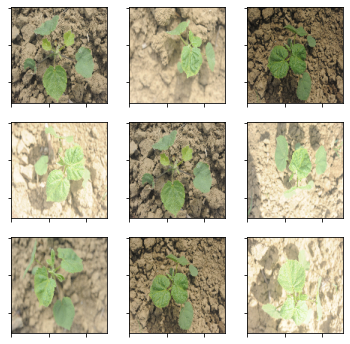

In [10]:
# Class 1
plot_sample(X[y == 1])

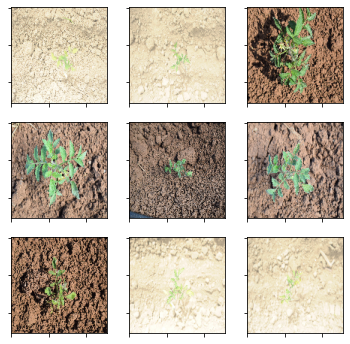

In [11]:
# Class 2
plot_sample(X[y == 2])

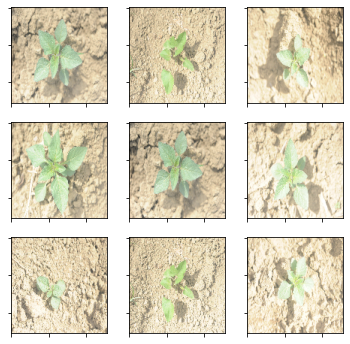

In [12]:
# Class 3
plot_sample(X[y == 3])

<a id='constants'></a>
#### Experimental Constants

In [32]:
EPOCHS = 50 # How many epochs each architecture is going to be trained for
MAX_TRIALS = 15 # Maximum trials for finding the best performing architecture
TUNER = "bayesian" # Select between 'greedy', 'bayesian', 'hyperband' or 'random'
BATCH_SIZE = 24 # How many images are used for computing loss
PERFORMANCE_OBJECTIVE = "val_accuracy" # Metric to be optimized

# Dataset Split Setting
TEST_SPLIT = 0.25
VAL_SPLIT = 0.15

RANDOM_STATE = 2021 # Set Seed for reproducibility purposes
WEIGHTS_FILE = 'weights.h5' # File to store the optimal model weights

#### Data preprocessing and dataset splitting among train-val-test sets

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = TEST_SPLIT, 
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size = VAL_SPLIT, 
                                                  stratify = y_train,
                                                  random_state = RANDOM_STATE)

### First approach
In this first example, we are using the [**ImageClassifier**](https://autokeras.com/image_classifier/) class, which tries every possible architecture combination, according to the search algorithm used. This approach may have the disadvantage of searching for solitions which may not be optimal from different points of view. For instance, rotating a crop vertically would not make sense for some image capturing applications. This issue will be addressed in the [second example](#second_example).

#### Creating the ImageClassifier object for searching the best architecture
**Warning**: Check [experimental constants](#constants) for more information.

In [34]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite = True, 
                         tuner = TUNER,
                         objective = PERFORMANCE_OBJECTIVE,
                         max_trials = MAX_TRIALS)

#### Searching for the best architecture

In [35]:
# Feed the image classifier with training data.
clf.fit(X_train, 
        y_train,
        callbacks = get_callbacks(WEIGHTS_FILE,
                                  EPOCHS//5),
        batch_size = BATCH_SIZE,
        validation_data = (X_val, y_val),
        epochs = EPOCHS)

Trial 15 Complete [00h 00m 59s]
val_accuracy: 0.9649122953414917

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 22m 45s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### Evaluating model with default Accuracy metric

In [58]:
# Evaluate the best model with testing data
print(clf.evaluate(X_test, y_test))

4/4 [==============================] - 2s 90ms/step - loss: 15.1193 - accuracy: 0.9440
[15.119271278381348, 0.9440000057220459]


#### Displaying the best architecture found by AutoKeras (after N trials)
**Disclaimer**: This is the best architecture found after the number of trials specified in MAX_TRIALS variable. If this value is increased, the architecture (and final performances) may differ.

In [57]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 128, 128, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0     

#### Saving model for future use without need for retraining

In [46]:
try:
    model.save("model_autokeras", save_format = "tf")
except Exception:
    model.save("model_autokeras.h5")

INFO:tensorflow:Assets written to: model_autokeras/assets


#### Reloading the previously stored model

In [59]:
loaded_model = load_model("model_autokeras", 
                          custom_objects = ak.CUSTOM_OBJECTS)

#### Checking final performance on test set
Instead of using the basic accuracy metric, we select the F<sub>1</sub>-score with the different averaging approaches. Check out their [advantages and disadvantages](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin).

In [61]:
predicted_y = loaded_model.predict(X_test).astype(np.uint8)
predicted_y = np.argmax(predicted_y, axis = -1)
print("Micro-F1: %.3f" % f1_score(y_test, predicted_y, average="micro"))
print("Macro-F1: %.3f" % f1_score(y_test, predicted_y, average="macro"))

Micro-F1: 0.944
Macro-F1: 0.937


<a id='second_example'></a>
### Second approach under a more constrained search space

Sometimes it is possible to speed up the hyper-parameter search by providing some constant architecture settings that can be based on previous evidence and scientific research. The way of implementing this option with AutoKeras is by using AutoModel instead of ImageClassifier, as shown in the previous example. Different blocks, such as the [Xception](https://arxiv.org/abs/1610.02357) or the [ResNet](https://arxiv.org/abs/1512.03385) ones, can be directly used and even merged for integrated feature extraction. Pre-processing steps can also be configured with their respective blocks (Normalization and ImageAugmentation). Check the [AutoKeras documentation](https://autokeras.com/block/) to explore all the available blocks.

#### Creating the AutoModel object for searching the best architecture

In [66]:
input_node = ak.ImageInput()
prep_node = ak.Normalization()(input_node)
prep_node = ak.ImageAugmentation(vertical_flip = False)(prep_node)
featExt_node1 = ak.XceptionBlock()(prep_node)
featExt_node2 = ak.ResNetBlock(version = "v2")(prep_node)
out_node = ak.Merge()([featExt_node1, featExt_node2])
out_node_c = ak.ClassificationHead()(out_node)
clf = ak.AutoModel(inputs = input_node, 
                  outputs = [out_node_c], 
                  overwrite = True, 
                  tuner = TUNER,
                  objective = 'val_accuracy',
                  max_trials = MAX_TRIALS)

#### Searching for the best architecture

In [67]:
# Feed the image classifier with training data
clf.fit(X_train, 
        y_train,
        callbacks = get_callbacks(WEIGHTS_FILE,
                                  EPOCHS//5),
        batch_size = BATCH_SIZE,
        validation_data = (X_val, y_val),
        epochs = EPOCHS)

Trial 15 Complete [00h 05m 48s]
val_accuracy: 0.9298245906829834

Best val_accuracy So Far: 0.9473684430122375
Total elapsed time: 01h 36m 29s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


#### Evaluating model with default Accuracy metric

In [77]:
# Evaluate the best model with testing data
print(clf.evaluate(X_test, y_test))

4/4 [==============================] - 6s 478ms/step - loss: 0.2805 - accuracy: 0.8960
[0.28054559230804443, 0.8960000276565552]


#### Displaying the best architecture found by AutoKeras (after N trials)
**Disclaimer:** This is the best architecture found after the number of trials specified in MAX_TRIALS variable. If this value is increased, the architecture (and final performances) may differ.

In [78]:
model = clf.export_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           cast_to_float32[0][0]            
__________________________________________________________________________________________________
resizing (Resizing)             (None, 224, 224, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

#### Checking final performance on test set

In [114]:
predicted_y = clf.predict(X_test).astype(np.uint8)
predicted_y = predicted_y.reshape(predicted_y.shape[0])
print("Micro-F1: %.3f" % f1_score(y_test, predicted_y, average="micro"))
print("Macro-F1: %.3f" % f1_score(y_test, predicted_y, average="macro"))

Micro-F1: 0.896
Macro-F1: 0.862


## Possible Extensions
1. Use different tuner: greedy, hyperband or random searches are available.
2. Change the epochs and batch size.
3. Change the image size.
4. Try other customized search space in the second example.

## Bibliography
<a id='references'></a>
Feurer, M.; Klein, A.; Eggensperger, K.; Springenberg, J.; Blum, M.; Hutter, F. Efficient and robust automated machine learning. Adv. Neural. Inf. Process. Syst. 2015, 28, 2962–2970.

Kotthoff, L.; Thornton, C.; Hoos, H.H.; Hutter, F.; Leyton-Brown, K. Auto-WEKA 2.0: Automatic model selection and hyperparameter optimization in WEKA. J. Mach. Learn. Res. 2017, 18, 826–830.

Hsieh, J.Y.; Huang, W.; Yang, H.T.; Lin, C.C.; Fan, Y.C.; Chen, H. Building the Rice Blast Disease Prediction Model Based on Machine Learning and Neural Networks; EasyChair: Manchester, UK, 2019.

Kiala, Z.; Mutanga, O.; Odindi, J.; Peerbhay, K.Y.; Slotow, R. Automated classification of a tropical landscape infested by Parthenium weed (Parthenium hyterophorus). J. Remote Sens. 2020, 41, 8497–8519

Koh, J.C.; Spangenberg, G.; Kant, S. Automated Machine Learning for High-Throughput Image-Based Plant Phenotyping. bioRxiv 2020.

Espejo-Garcia, B.; Malounas I.; Vali, E.; Fountas, S. Testing the Suitability of Automated Machine Learning for Weeds Identification. AI. 2021. 

https://autokeras.com/